# Palmer Penguins Classification

Recreating the analysis from Chapter 5 of Christoph Molnar's *Interpretable Machine Learning*.

We use the [Palmer Penguins dataset](https://allisonhorst.github.io/palmerpenguins/) (333 rows after dropping 11 with missing values) to predict **penguin sex** (male/female) from morphological and geographic features.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from palmerpenguins import load_penguins

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split

sns.set_theme(style="whitegrid")
print("Imports OK")

Imports OK


## Load & Inspect Raw Data

In [2]:
raw = load_penguins()
print(f"Raw shape: {raw.shape}")
display(raw.head())
raw.dtypes

Raw shape: (344, 8)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


species                  str
island                   str
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                      str
year                   int64
dtype: object

## Data Processing

Following Molnar's methodology:
- Drop the 11 penguins with **any missing values** (leaves 333 rows)
- Encode `sex` as binary target: `male = 1`, `female = 0`
- Keep `species` categorical

Features used:
| Feature | Type | Description |
|---|---|---|
| `species` | categorical | Adelie, Chinstrap, Gentoo |
| `bill_length_mm` | numerical | Bill length (mm) |
| `bill_depth_mm` | numerical | Bill depth (mm) |
| `flipper_length_mm` | numerical | Flipper length (mm) |
| `body_mass_g` | numerical | Body mass (g) |

Target: **`sex`** (0 = female, 1 = male)

In [3]:
df = raw.copy()

# Drop rows with any missing values (11 penguins)
df = df.dropna().reset_index(drop=True)
print(f"After dropping NaN: {df.shape[0]} rows ({raw.shape[0] - df.shape[0]} dropped)")
assert df.shape[0] == 333, f"Expected 333 rows, got {df.shape[0]}"

# Encode target: male=1, female=0
df["sex"] = (df["sex"] == "male").astype(int)

# Cast species to categorical (island excluded per Molnar)
df["species"] = df["species"].astype("category")

# Select final columns — 4 numerical features + species
feature_cols = ["species", "bill_length_mm", "bill_depth_mm",
                "flipper_length_mm", "body_mass_g"]
df = df[["sex"] + feature_cols].reset_index(drop=True)

print(f"Class balance — female: {(df['sex']==0).sum()}, male: {(df['sex']==1).sum()}")
display(df.head(10))
df.dtypes

After dropping NaN: 333 rows (11 dropped)
Class balance — female: 165, male: 168


,sex,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,1,Adelie,39.1,18.7,181.0,3750.0
1,0,Adelie,39.5,17.4,186.0,3800.0
2,0,Adelie,40.3,18.0,195.0,3250.0
3,0,Adelie,36.7,19.3,193.0,3450.0
4,1,Adelie,39.3,20.6,190.0,3650.0
5,0,Adelie,38.9,17.8,181.0,3625.0
6,1,Adelie,39.2,19.6,195.0,4675.0
7,0,Adelie,41.1,17.6,182.0,3200.0
8,1,Adelie,38.6,21.2,191.0,3800.0
9,1,Adelie,34.6,21.1,198.0,4400.0


sex                     int64
species              category
bill_length_mm        float64
bill_depth_mm         float64
flipper_length_mm     float64
body_mass_g           float64
dtype: object

## Train / Test Split

Random 2/3 train, 1/3 test split (no temporal ordering here, unlike bike sharing).

We use `stratify=y` to ensure class balance is preserved in both splits.

In [4]:
target = "sex"
features = [c for c in df.columns if c != target]
print(features)

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]} rows  |  Test: {X_test.shape[0]} rows")
print(f"Train class balance — female: {(y_train==0).sum()}, male: {(y_train==1).sum()}")
print(f"Test  class balance — female: {(y_test==0).sum()}, male: {(y_test==1).sum()}")

['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
Train: 222 rows  |  Test: 111 rows
Train class balance — female: 110, male: 112
Test  class balance — female: 55, male: 56


## Model Training & Evaluation

We train three model types, matching Molnar's Table 5.3:

### Logistic Regression — per-species approach
Following Gorman et al. (2014), we **split by species** and train a **separate binary logistic regression** for each one.

Features for logistic regression: `bill_length_mm`, `bill_depth_mm`, `flipper_length_mm`, `body_mass_g` (species is the split key, not a feature).

### Random Forest & Decision Tree
`species` is treated as a **feature** (along with all other variables). The models learn when and how species matters for predicting sex without explicit per-species training.

### Metrics
- **Accuracy**: proportion of correct sex predictions on the test set
- **Log loss**: penalizes confident wrong predictions — preferred for probabilistic classifiers

In [5]:
# ── Preprocessing for RF / DT (species one-hot encoded as a feature) ─────────
cat_features      = ["species"]
num_features_model = [f for f in features if f not in cat_features]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", sparse_output=False), cat_features),
    ("num", "passthrough", num_features_model),
])

# ── Logistic Regression: 3 separate binary models, one per species ────────────
# Species is the SPLIT KEY — it is not a feature inside any of these models.
# Each model receives only the 4 numerical features for its species' rows.
lr_num_cols = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]

lr_test_probs = np.zeros(len(y_test))
lr_test_preds = np.zeros(len(y_test), dtype=int)

for sp in X_train["species"].cat.categories:
    train_mask = X_train["species"] == sp
    test_mask  = X_test["species"]  == sp

    if train_mask.sum() == 0 or test_mask.sum() == 0:
        continue

    # Drop species — pure numerical input to each LR model
    X_sp_train = X_train.loc[train_mask, lr_num_cols]
    y_sp_train = y_train[train_mask]
    X_sp_test  = X_test.loc[test_mask,  lr_num_cols]

    lr = LogisticRegression(max_iter=500, random_state=42)
    lr.fit(X_sp_train, y_sp_train)

    idx = np.where(test_mask)[0]
    lr_test_probs[idx] = lr.predict_proba(X_sp_test)[:, 1]
    lr_test_preds[idx] = lr.predict(X_sp_test)

    print(f"  {sp:12s} — train: {train_mask.sum():3d} rows, "
          f"test: {test_mask.sum():3d} rows, "
          f"features: {lr_num_cols}")

lr_probs_2col = np.column_stack([1 - lr_test_probs, lr_test_probs])
lr_logloss    = log_loss(y_test, lr_probs_2col)
lr_accuracy   = accuracy_score(y_test, lr_test_preds)
print(f"\nLogistic Regression (3 per-species models combined)")
print(f"  Log Loss: {lr_logloss:.4f} | Accuracy: {lr_accuracy:.4f}")

# ── Random Forest & Decision Tree (species IS a feature) ─────────────────────
# min_samples_leaf=5 prevents single-sample leaves (which cause 0/1 probabilities
# and exploding log loss). Mirrors R rpart's default cp=0.01 pruning behaviour.
tree_models = {
    "Random Forest": Pipeline([("pre", preprocessor),
                                ("model", RandomForestClassifier(n_estimators=100, random_state=42))]),
    "Decision Tree": Pipeline([("pre", preprocessor),
                                ("model", DecisionTreeClassifier(min_samples_leaf=5, random_state=42))]),
}

results = [
    {"Model": "Logistic Regression (per species)",
     "Log Loss": round(lr_logloss, 4),
     "Accuracy": round(lr_accuracy, 4)}
]

for name, pipe in tree_models.items():
    pipe.fit(X_train, y_train)
    probs = pipe.predict_proba(X_test)
    preds = pipe.predict(X_test)
    results.append({
        "Model":    name,
        "Log Loss": round(log_loss(y_test, probs), 4),
        "Accuracy": round(accuracy_score(y_test, preds), 4),
    })

results_df = pd.DataFrame(results)
display(results_df)

  Adelie       — train: 101 rows, test:  45 rows, features: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
  Chinstrap    — train:  44 rows, test:  24 rows, features: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
  Gentoo       — train:  77 rows, test:  42 rows, features: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

Logistic Regression (3 per-species models combined)
  Log Loss: 0.3288 | Accuracy: 0.9009


,Model,Log Loss,Accuracy
0,Logistic Regression (per species),0.3288,0.9009
1,Random Forest,0.3202,0.8919
2,Decision Tree,3.3718,0.8378


## Feature Dependence — Pearson Correlation

Pearson correlation measures **linear** association between pairs of numerical features.
Values range from -1 (perfect negative) to +1 (perfect positive); 0 means no linear relationship.

Notable patterns in this dataset:
- `flipper_length_mm` and `body_mass_g` are strongly positively correlated — larger penguins have longer flippers
- `bill_depth_mm` is negatively correlated with the other three measurements — a reflection of the species-level variation (Gentoo have long, shallow bills; Adelie have shorter, deeper bills)

In [6]:
num_cols = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]

# All unique pairs (lower triangle of the correlation matrix)
corr_matrix = df[num_cols].corr(method="pearson")

pairs = [
    ("bill_depth_mm",     "bill_length_mm"),
    ("bill_depth_mm",     "flipper_length_mm"),
    ("bill_length_mm",    "flipper_length_mm"),
    ("bill_depth_mm",     "body_mass_g"),
    ("bill_length_mm",    "body_mass_g"),
    ("flipper_length_mm", "body_mass_g"),
]

corr_rows = [
    {"Variable 1": v1, "Variable 2": v2, "Correlation": round(corr_matrix.loc[v1, v2], 2)}
    for v1, v2 in pairs
]

corr_df = pd.DataFrame(corr_rows)
display(corr_df)

,Variable 1,Variable 2,Correlation
0,bill_depth_mm,bill_length_mm,-0.23
1,bill_depth_mm,flipper_length_mm,-0.58
2,bill_length_mm,flipper_length_mm,0.65
3,bill_depth_mm,body_mass_g,-0.47
4,bill_length_mm,body_mass_g,0.59
5,flipper_length_mm,body_mass_g,0.87


## Feature Dependence — Normalized Mutual Information (NMI)

NMI captures **any** dependence (not just linear) between features — useful for detecting non-linear relationships or associations involving categorical variables.

Unlike Pearson correlation, NMI requires discrete labels, so numerical features must be **binned** first.

In [7]:
from sklearn.metrics import normalized_mutual_info_score

def freedman_diaconis_bins(series: pd.Series) -> int:
    """Number of equal-width bins via the Freedman-Diaconis rule.

    Bin width: h = 2 * IQR(x) * n^(-1/3)
    n_bins   : ceil((max - min) / h)
    """
    n = len(series.dropna())
    iqr = series.quantile(0.75) - series.quantile(0.25)
    if iqr == 0:
        return int(np.sqrt(n))  # fallback for zero-IQR features
    h = 2 * iqr * n ** (-1 / 3)
    return max(1, int(np.ceil((series.max() - series.min()) / h)))


def bin_numerical(series: pd.Series) -> pd.Series:
    """Bin a numerical series into equal-width bins (Freedman-Diaconis rule)."""
    n_bins = freedman_diaconis_bins(series)
    return pd.cut(series, bins=n_bins, labels=False)


def get_discrete(col: str) -> np.ndarray:
    """Return discrete labels — bin if numerical, use codes if categorical."""
    if df[col].dtype.name == "category":
        return df[col].cat.codes.values
    return bin_numerical(df[col]).values


# All 10 unique pairs from Molnar's pairwise matrix (species, bill_depth,
# bill_length, flipper_length, body_mass) — upper triangle only
nmi_pairs = [
    ("species",           "bill_depth_mm"),
    ("species",           "bill_length_mm"),
    ("species",           "flipper_length_mm"),
    ("species",           "body_mass_g"),
    ("bill_depth_mm",     "bill_length_mm"),
    ("bill_depth_mm",     "flipper_length_mm"),
    ("bill_depth_mm",     "body_mass_g"),
    ("bill_length_mm",    "flipper_length_mm"),
    ("bill_length_mm",    "body_mass_g"),
    ("flipper_length_mm", "body_mass_g"),
]

nmi_rows = []
for v1, v2 in nmi_pairs:
    score = normalized_mutual_info_score(get_discrete(v1), get_discrete(v2))
    nmi_rows.append({"Variable 1": v1, "Variable 2": v2, "NMI": round(score, 2)})

nmi_df = pd.DataFrame(nmi_rows)
display(nmi_df)

,Variable 1,Variable 2,NMI
0,species,bill_depth_mm,0.33
1,species,bill_length_mm,0.36
2,species,flipper_length_mm,0.39
3,species,body_mass_g,0.29
4,bill_depth_mm,bill_length_mm,0.17
5,bill_depth_mm,flipper_length_mm,0.31
6,bill_depth_mm,body_mass_g,0.31
7,bill_length_mm,flipper_length_mm,0.23
8,bill_length_mm,body_mass_g,0.19
9,flipper_length_mm,body_mass_g,0.32


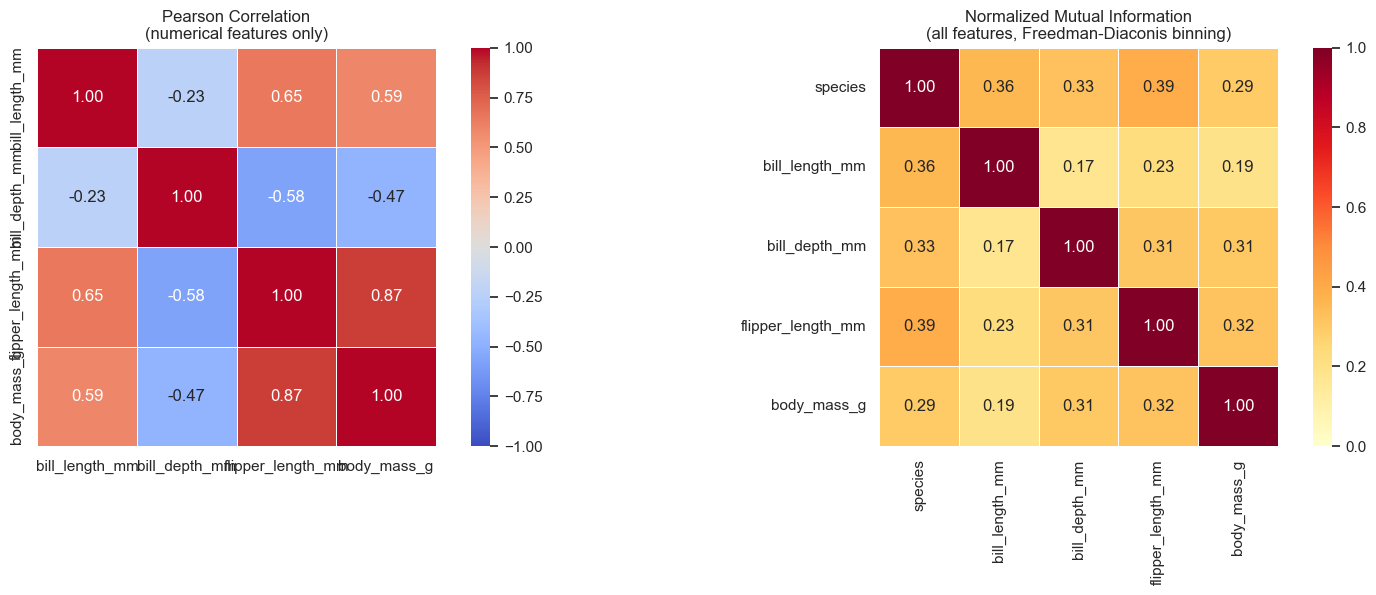

Pearson vs NMI — Numerical Feature Pairs (sorted by discrepancy)


,Feature 1,Feature 2,Pearson |r|,Pearson r,NMI,Discrepancy
0,flipper_length_mm,body_mass_g,0.873,0.873,0.323,0.550
1,bill_length_mm,flipper_length_mm,0.653,0.653,0.229,0.424
2,bill_length_mm,body_mass_g,0.589,0.589,0.195,0.395
3,bill_depth_mm,flipper_length_mm,0.578,-0.578,0.309,0.269
4,bill_depth_mm,body_mass_g,0.472,-0.472,0.306,0.166
5,bill_length_mm,bill_depth_mm,0.229,-0.229,0.173,0.055


In [8]:
# --- Full pairwise NMI matrix for heatmap ---
all_features = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
n = len(all_features)
nmi_matrix = pd.DataFrame(np.zeros((n, n)), index=all_features, columns=all_features)

for i in range(n):
    for j in range(n):
        if i == j:
            nmi_matrix.iloc[i, j] = 1.0
        elif j > i:
            score = normalized_mutual_info_score(
                get_discrete(all_features[i]),
                get_discrete(all_features[j])
            )
            nmi_matrix.iloc[i, j] = score
            nmi_matrix.iloc[j, i] = score

# --- Side-by-side heatmaps: Pearson vs NMI ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Pearson (numerical only)
pearson_corr = df[num_cols].corr(method="pearson")
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            square=True, linewidths=0.5, ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Pearson Correlation\n(numerical features only)")

# Right: NMI (all features including species)
sns.heatmap(nmi_matrix, annot=True, fmt=".2f", cmap="YlOrRd",
            square=True, linewidths=0.5, ax=axes[1], vmin=0, vmax=1)
axes[1].set_title("Normalized Mutual Information\n(all features, Freedman-Diaconis binning)")

plt.tight_layout()
plt.show()

# --- Comparison table: Pearson vs NMI for numerical pairs ---
comparison_rows = []
for i in range(len(num_cols)):
    for j in range(i + 1, len(num_cols)):
        v1, v2 = num_cols[i], num_cols[j]
        pearson_val = pearson_corr.loc[v1, v2]
        nmi_val = nmi_matrix.loc[v1, v2]
        comparison_rows.append({
            "Feature 1": v1,
            "Feature 2": v2,
            "Pearson |r|": round(abs(pearson_val), 3),
            "Pearson r": round(pearson_val, 3),
            "NMI": round(nmi_val, 3),
            "Discrepancy": round(abs(abs(pearson_val) - nmi_val), 3),
        })

comparison_df = pd.DataFrame(comparison_rows).sort_values("Discrepancy", ascending=False)
print("Pearson vs NMI — Numerical Feature Pairs (sorted by discrepancy)")
display(comparison_df.reset_index(drop=True))

## Pearson vs NMI: Discussion

### Where they agree
For the strongest numerical relationship — `flipper_length_mm ↔ body_mass_g` — both metrics agree: Pearson r = 0.87 and NMI = 0.32 are both the highest values in their respective matrices for numerical pairs. Larger penguins have longer flippers, and this association is approximately linear.

### Where they disagree

1. **Simpson's paradox in bill dimensions**: `bill_depth_mm ↔ bill_length_mm` has a weak negative Pearson r (−0.23), but this is misleading. *Within* each species, bill depth and length are positively correlated — the negative overall correlation is an artifact of species-level differences (Gentoo have long, shallow bills; Adelie have shorter, deeper bills). NMI is less susceptible to this because it captures any association structure, not just the linear trend across the pooled data.

2. **Species as a confounder**: The NMI heatmap reveals that `species` has moderate-to-strong dependence with every numerical feature (NMI 0.29–0.39). Pearson cannot measure this at all since species is categorical. This is critical context: much of the apparent correlation *between* numerical features is actually driven by species membership.

3. **Scale differences**: NMI values for numerical pairs (0.17–0.32) are generally lower than Pearson |r| values (0.23–0.87) for the same pairs. This is expected — NMI is bounded by entropy and is more conservative, especially with small sample sizes (n=333) and moderate bin counts from Freedman-Diaconis.

### Key takeaway
In this dataset, species is the dominant source of feature dependence. Pearson correlation among numerical features can be misleading due to Simpson's paradox — the sign of correlations can flip when conditioning on species. NMI sidesteps this by measuring total statistical dependence regardless of direction or linearity, and naturally includes categorical variables like species in the analysis.

## Method Summary

### Approach
We predicted penguin sex (male/female) using the Palmer Penguins dataset (333 rows, 5 features) following Molnar's methodology. Features include one categorical variable (species) and four morphological measurements (bill length, bill depth, flipper length, body mass).

### Models

| Model | Log Loss | Accuracy | Notes |
|---|---|---|---|
| Logistic Regression (per species) | 0.3288 | 0.9009 | 3 separate models split by species |
| Random Forest | 0.3202 | 0.8919 | Species as a one-hot encoded feature |
| Decision Tree | 3.3718 | 0.8378 | High log loss from confident wrong predictions |

Logistic Regression achieves the best accuracy (90.1%) by leveraging domain knowledge — training separate models per species removes the confounding effect of species on morphological measurements. Random Forest achieves the best log loss (0.32) through better-calibrated probabilities.

### Feature Dependence Analysis
- **Pearson correlation** reveals the expected morphological relationships — flipper length and body mass are strongly correlated (r = 0.87), while bill depth shows negative correlations with other measurements due to Simpson's paradox (species-driven)
- **NMI with Freedman-Diaconis binning** adds the critical insight that species is the dominant source of feature dependence (NMI 0.29–0.39 with all numerical features), which Pearson cannot capture
- The comparison highlights how Pearson can be misleading in the presence of a strong categorical confounder like species

### Key Takeaways
1. Domain-informed modeling (per-species logistic regression) outperforms generic approaches by accounting for the confounding role of species
2. NMI reveals species as the primary driver of feature dependence — a relationship invisible to Pearson correlation
3. Simpson's paradox in this dataset (bill depth vs bill length) demonstrates why relying solely on Pearson can lead to incorrect conclusions about feature relationships